# FEATURED : **RSNA 2024 Lumbar Spine Degenerative Classification**

## >> **YOLO MODEL**

- [YOLO Training Explanation](https://www.kaggle.com/code/arindamroy23/yolo-training-explanation)

- [LSDC Yolo Approach](https://www.kaggle.com/code/namgalielei/lsdc-yolo-approach)

## 00. **SET WORK ENVORINMENT**

#### 00.1. **DEFINE PRE-VARIABELS**

In [4]:
#(1)
seed_num = 2024

#(2) ??
FOLD = 0

#(3) mage size 
OD_INPUT_SIZE = 384

#(4) Box size
STD_BOX_SIZE = 20

#(5) hyper-param
BATCH_SIZE = 64
EPOCHS = 50
SAMPLE = None
# 5 levels * 2 positions (left/right) * 3 conditions = 30 labels

#(6) dataset labels
CONDITIONS = ['Left Subarticular Stenosis', 'Right Subarticular Stenosis']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

#(7) file directory
file_path = f'../data/raw'
DATA_DIR = f'../data/data_fold{FOLD}'
IMG_DIR = f"{file_path}/train_images"

#### 00.2. **IMPORT PACKAGES AND SET OPTIONS**

In [18]:
#(1) Import packages
import os
import warnings
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import cv2
import glob
import wandb
from ultralytics import YOLO
# from wandb.integration.ultralytics import add_wandb_callback

#(2) Set system options
warnings.filterwarnings(action='ignore')
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_rows = 150

#### 00.3. **CREATE FUNCTIONS**

In [6]:
#(1)
def get_level(text):
    """
    This function takes a string input 'text' and searches for level indicators
    (such as 'l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1') within the text.
    
    If no level is found in the text, the function raises a ValueError.
    
    Example:
    - Input: "The project level is l3_l4."
    - Output: "L3/L4"
    """
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found: ' + lev)
    
#(2)  
def get_condition(text):
    """
    This function takes a string input 'text' where words are separated by underscores ('_'). 
    It splits the text into individual words, capitalizes each word, and removes the last two words. 
    The remaining words are then joined together into a single string, separated by spaces.

    Parameters:
    - text (str): The input string with words separated by underscores.

    Returns:
    - str: A string of capitalized words, with the last two words removed, and joined by spaces.

    Example:
    - Input: "example_text_to_modify"
    - Output: "Example Text"
    """
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)

#(3)
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    """
    This function queries a DataFrame `label_df` based on the provided study ID, 
    series ID, and instance number to retrieve the relevant rows.

    Depending on the combination of the `study_id`, `series_id`, and `instance_num` parameters, 
    it filters the DataFrame as follows:
    
    - If both `series_id` and `instance_num` are provided, the function returns rows 
      that match all three criteria (study_id, series_id, instance_num).
    - If neither `series_id` nor `instance_num` are provided, it returns rows that match only the `study_id`.
    - If only `series_id` is provided, it returns rows that match the `study_id` and `series_id`.

    Parameters:
    - study_id (int/str): The ID of the study to filter by.
    - series_id (int/str, optional): The ID of the series to filter by (default is None).
    - instance_num (int, optional): The instance number to filter by (default is None).

    Returns:
    - DataFrame: A filtered subset of `label_df` based on the provided criteria.

    Example:
    - Input: query_train_xy_row(1001, 2002, 3)
    - Output: Returns rows from `label_df` where `study_id` = 1001, `series_id` = 2002, and `instance_number` = 3.
    """
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]
    
#(4)
def read_dcm(src_path):
    # Reads DCMs
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

#(5)
def get_accronym(text):
    # Gets Acronyms
    split = text.split(' ')
    return ''.join([x[0] for x in split])


#### 00.4. **CREATE CLASSES**

In [7]:
pass

<b></b>

## 01. **READ AND CONCATENATE DATASETS**

##### 01.1. **READ DATASETS**

In [8]:
#(2) Read Datasets
train_desc_raw = pd.read_csv(filepath_or_buffer=f'{file_path}/train_series_descriptions.csv') # id 별 description ? (MRI 이미지 측정 기법?같은 설명인듯) 
train_coord_raw = pd.read_csv(filepath_or_buffer=f'{file_path}/train_label_coordinates.csv')  # 이미지 데이터의 좌표값(x, y) 
train_label_raw = pd.read_csv(filepath_or_buffer=f'{file_path}/train.csv')                    # 멀티 라벨(정답값배열) 
test_desc_raw = pd.read_csv(filepath_or_buffer=f'{file_path}/test_series_descriptions.csv')
submission_raw = pd.read_csv(filepath_or_buffer=f'{file_path}/sample_submission.csv')

<b></b>

## 02. **TEMP**

In [9]:
# Read train data 
train_val_df = train_label_raw
train_xy = train_coord_raw
train_des = train_desc_raw

# if SAMPLE :
#     train_val_df = train_val_df.sample(SAMPLE, random_state=2698)
    
# Presplit for folds
fold_df = pd.read_csv(f'../data/5fold.csv')

# print('Unique conditions  >   ', train_xy['condition'].unique())

#(5)
train_coord_raw.head(n=3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.8319,227.9646
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.5714,295.7143
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.0303,371.8182


<b></b>

## 03. **MERGE DATASET**

In [10]:
# For every study_id, we get corresponding condition level and label and assign a fold 
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
label_df = pd.DataFrame(label_df)
# Assigning Fold
label_df = label_df.merge(fold_df, on='study_id')
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])
del train_xy
# Create df for current disease conditions only
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

#Dicts for mapping label <-> ID both ways 
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

# Train val creation 
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

filtered_df.head()

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
15,4003253,Left Subarticular Stenosis,L1/L2,Normal/Mild,0,2448190387,3,179.1264,161.2355,Axial T2
16,4003253,Left Subarticular Stenosis,L2/L3,Normal/Mild,0,2448190387,11,180.9797,158.7645,Axial T2
17,4003253,Left Subarticular Stenosis,L3/L4,Normal/Mild,0,2448190387,19,176.0376,157.5290,Axial T2
18,4003253,Left Subarticular Stenosis,L4/L5,Moderate,0,2448190387,28,172.9488,156.9112,Axial T2
19,4003253,Left Subarticular Stenosis,L5/S1,Normal/Mild,0,2448190387,35,179.7442,161.8533,Axial T2


<b></b>

## 04. **TEMP**

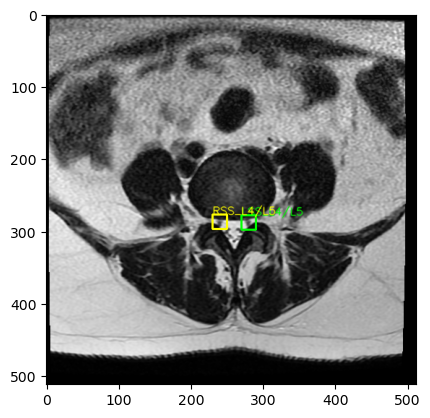

In [11]:
ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    # condition_level
    lbl = f"{get_accronym(row['condition'])}_{row['level']}"
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255,255,0) 
    elif row['label'] == 'Severe':
        color = (255,0,0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

# print(tmp_df)

plt.imshow(img)
plt.show()

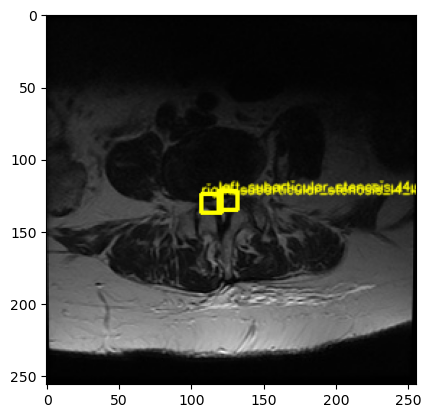

In [17]:
# test generated annotations

_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]
# print(name)

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
    if _cls == 0:
        c = (255,0,0)
    elif _cls == 1:
        c = (0,255,0)
    else:
        c = (255,255,0)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)
plt.imshow(im)
plt.show()

<b></b>

## 05. **TEMP**

In [1]:
# # Initialize YOLO Model
# model = YOLO(model="../output/best.pt")

# # Add W&B callback for Ultralytics
# # wandb.integration.ultralytics.add_wandb_callback(model, enable_model_checkpointing=True)

# model.train(project="lsdc_yolov8", data="yolo_scs.yaml", 
#             epochs=EPOCHS, imgsz=OD_INPUT_SIZE, batch=BATCH_SIZE)

# # Finish the W&B run
# wandb.finish()

<b></b>